# Terry Stop Analysis
### In the 1968 Supreme Court case "Terry v. Ohio", the court found that a police officer was not in vilation of the "unresonable search and seizure" clause of the Fourth Amendment after he stopped and frisked suspects only because their behavior was suspicious. Thus the phrase "Terry Stops" are in reference to stops made of suspicious drivers. 

This is an analysis of over 48,000 Terry Stops, with a goal of predicting if an arrest will be made based off time of day, whether a suspect was frisked, and racial & gender demographics of both the suspects and officers. 

The overall goal of the analysis is to have the highest possible recall, to minimize false positives, of accidentally classifying subject who were not arrested as arrested. 




In [117]:
#import the necessary libraries. 


import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Step 1: Cleaning the Data

In [2]:
# Import and look at the rows of our dataset. 

pd.set_option('display.max_columns', None)
df = pd.read_csv('Terry_Stops.csv')
df.head()


,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,-,-,2015-03-19T00:00:00,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,White,Male,2015-03-21T00:00:00,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,-,-,2015-04-01T00:00:00,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,Black or African American,Male,2015-04-03T00:00:00,00:41:00,-,-,-,NaN,N,N,-,-,-


In [3]:
# For ease of analysis, let's add underscores to each column name
renamed_columns = ['Subject_Age_Group','Subject_ID', 'GO_SC_Num', 'Terry_Stop_ID',
                   'Stop_Resolution', 'Weapon_Type', 'Officer_ID', 'Officer_YOB',
                  'Officer_Gender', 'Officer_Race', 'Subject_Perceived_Race',
                  'Subject_Perceived_Gender', 'Reported_Date', 'Reported_Time',
                   'Initial_Call_Type', 'Final_Call_Type', 'Call_Type', 'Officer_Squad',
                  'Arrest_Flag', 'Frisk_Flag','Precinct', 'Sector', 'Beat']
df.columns = renamed_columns
df.head()

,Subject_Age_Group,Subject_ID,GO_SC_Num,Terry_Stop_ID,Stop_Resolution,Weapon_Type,Officer_ID,Officer_YOB,Officer_Gender,Officer_Race,Subject_Perceived_Race,Subject_Perceived_Gender,Reported_Date,Reported_Time,Initial_Call_Type,Final_Call_Type,Call_Type,Officer_Squad,Arrest_Flag,Frisk_Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,Asian,Male,2015-10-16T00:00:00,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,-,-,2015-03-19T00:00:00,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,White,Male,2015-03-21T00:00:00,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,-,-,2015-04-01T00:00:00,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,Black or African American,Male,2015-04-03T00:00:00,00:41:00,-,-,-,NaN,N,N,-,-,-


In [4]:
# Looking at the initial data, 'Subject_ID, GO_SC_Num', 'Terry_Stop_ID', and 'Officer_ID' are purely 
# individual indentifiers so it's okay to drop those

In [5]:
df = df.drop(['Subject_ID','GO_SC_Num', 'Terry_Stop_ID', 'Officer_ID'], axis=1)

In [6]:
# Take a look to see if there are any null values in the data 

df.isna().sum()

Subject_Age_Group             0
Stop_Resolution               0
Weapon_Type                   0
Officer_YOB                   0
Officer_Gender                0
Officer_Race                  0
Subject_Perceived_Race        0
Subject_Perceived_Gender      0
Reported_Date                 0
Reported_Time                 0
Initial_Call_Type             0
Final_Call_Type               0
Call_Type                     0
Officer_Squad               605
Arrest_Flag                   0
Frisk_Flag                    0
Precinct                      0
Sector                        0
Beat                          0
dtype: int64

In [7]:
# Interesting, because upon initial analysis, there are empty entries 
# in 'Subject Age Group', all of the 'Call Type' columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48094 entries, 0 to 48093
Data columns (total 19 columns):
Subject_Age_Group           48094 non-null object
Stop_Resolution             48094 non-null object
Weapon_Type                 48094 non-null object
Officer_YOB                 48094 non-null int64
Officer_Gender              48094 non-null object
Officer_Race                48094 non-null object
Subject_Perceived_Race      48094 non-null object
Subject_Perceived_Gender    48094 non-null object
Reported_Date               48094 non-null object
Reported_Time               48094 non-null object
Initial_Call_Type           48094 non-null object
Final_Call_Type             48094 non-null object
Call_Type                   48094 non-null object
Officer_Squad               47489 non-null object
Arrest_Flag                 48094 non-null object
Frisk_Flag                  48094 non-null object
Precinct                    48094 non-null object
Sector                      48094 non-null

In [8]:
# investigate the columns that are mostly '-' to see if there is data 
# or if it's mostly null values

In [9]:
print('Subject Age Group:' , '\n', df['Subject_Age_Group'].value_counts(),'\n')
print('Initial Call Type:', '\n', df['Initial_Call_Type'].value_counts(),'\n')
print('Final Call Type:', '\n',  df['Final_Call_Type'].value_counts(), '\n')
print('Call Type:', "\n", df['Call_Type'].value_counts(),'\n')

Subject Age Group: 
 26 - 35         16012
36 - 45         10262
18 - 25          9590
46 - 55          6225
56 and Above     2448
1 - 17           1986
-                1571
Name: Subject_Age_Group, dtype: int64 

Initial Call Type: 
 -                                                 13207
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW         3221
SUSPICIOUS PERSON, VEHICLE OR INCIDENT             3078
DISTURBANCE, MISCELLANEOUS/OTHER                   2477
ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS)     2070
                                                  ...  
ORDER - ASSIST DV VIC W/SRVC OF COURT ORDER           1
INJURED -  PERSON/INDUSTRIAL ACCIDENT                 1
DEMONSTRATIONS                                        1
-ASSIGNED DUTY - STAKEOUT                             1
ALARM - ATM MACHINE, FREE STANDING                    1
Name: Initial_Call_Type, Length: 168, dtype: int64 

Final Call Type: 
 -                                                   13207
--SUSPICIOUS CIRCU

In [10]:
# From this it seems like all "Call Type" is mostly unnecessary and can be dropped. Also 'Initial_Call_Type'
# and 'Final_Call_Type' are missing over 13k columns so it's okay to drop those

In [11]:
df = df.drop(['Call_Type','Initial_Call_Type', 'Final_Call_Type'], axis=1)

In [12]:
df['Subject_Age_Group'].value_counts()

26 - 35         16012
36 - 45         10262
18 - 25          9590
46 - 55          6225
56 and Above     2448
1 - 17           1986
-                1571
Name: Subject_Age_Group, dtype: int64

In [13]:
df = df = df[df.Subject_Age_Group != '-']

In [14]:
df['Subject_Age_Group'].value_counts()

26 - 35         16012
36 - 45         10262
18 - 25          9590
46 - 55          6225
56 and Above     2448
1 - 17           1986
Name: Subject_Age_Group, dtype: int64

In [15]:
df['Officer_YOB'].value_counts()

1986    3261
1987    2934
1984    2691
1991    2659
1985    2440
1992    2426
1990    2274
1988    2114
1989    2010
1982    1833
1983    1681
1979    1493
1993    1482
1981    1406
1995    1232
1971    1182
1978    1137
1977     994
1976     993
1994     905
1973     904
1980     809
1967     701
1996     687
1968     590
1970     559
1969     539
1974     533
1975     521
1997     451
1962     449
1964     431
1972     413
1965     412
1963     236
1958     215
1961     206
1966     178
1959     167
1960     128
1954      44
1957      43
1998      36
1953      33
1900      31
1955      21
1956      17
1948      10
1949       5
1952       4
1946       2
1951       1
Name: Officer_YOB, dtype: int64

In [16]:
def officer_yob_decade(x):
    if (x <= 1959):
        return '1900-1960'
    elif (x > 1959) and (x <= 1969):
        return '1960s'
    elif (x > 1969) and (x <= 1979):
        return '1970s'
    elif (x > 1979) and (x <= 1989):
        return '1980s'
    elif (x > 1989) and (x <= 1999):
        return '1990s'
    

In [17]:
df['Officer_Age_By_Decade'] = df['Officer_YOB'].apply(officer_yob_decade)
df['Officer_Age_By_Decade'].value_counts()

1980s        21179
1990s        12152
1970s         8729
1960s         3870
1900-1960      593
Name: Officer_Age_By_Decade, dtype: int64

In [18]:
# Explore "Arrest Flag" and "Stop Resolution
#a s they both have arrest data that will serve
# as the target variable for this exploration. 

In [19]:
df['Arrest_Flag'].value_counts()

N    42843
Y     3680
Name: Arrest_Flag, dtype: int64

In [20]:
df['Stop_Resolution'].value_counts()

Field Contact               18637
Offense Report              15287
Arrest                      11706
Referred for Prosecution      719
Citation / Infraction         174
Name: Stop_Resolution, dtype: int64

In [21]:
# It seems there is a discrepency in Arrest data between 'Stop Resolution'
# and "Arrest_Flag". I am making the executive decision to base this 
# exploration around "Stop Resolution" as it reads as more thorough
# in it's reporting of resoltion rather than a simple 'Yes'/'No' in 
# 'Arrest Flag'.

In [22]:
df['Stop_Resolution'] = df['Stop_Resolution'].apply(lambda x: 'Yes' if x == 'Arrest' else 'No')
df['Stop_Resolution'].value_counts()

No     34817
Yes    11706
Name: Stop_Resolution, dtype: int64

In [23]:
df = df.drop('Arrest_Flag', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46523 entries, 124 to 48093
Data columns (total 16 columns):
Subject_Age_Group           46523 non-null object
Stop_Resolution             46523 non-null object
Weapon_Type                 46523 non-null object
Officer_YOB                 46523 non-null int64
Officer_Gender              46523 non-null object
Officer_Race                46523 non-null object
Subject_Perceived_Race      46523 non-null object
Subject_Perceived_Gender    46523 non-null object
Reported_Date               46523 non-null object
Reported_Time               46523 non-null object
Officer_Squad               45936 non-null object
Frisk_Flag                  46523 non-null object
Precinct                    46523 non-null object
Sector                      46523 non-null object
Beat                        46523 non-null object
Officer_Age_By_Decade       46523 non-null object
dtypes: int64(1), object(15)
memory usage: 6.0+ MB


In [24]:
# Now explore factors like the races and genders of both the officers
# and the people pulled over

In [25]:
print('Officer Gender:' , '\n', df['Officer_Gender'].value_counts(),'\n')
print('Officer Race:', '\n', df['Officer_Race'].value_counts(),'\n')
print('Subject Perceived Gender:', '\n',  df['Subject_Perceived_Gender'].value_counts(), '\n')
print('Subject Perceived Race:', "\n", df['Subject_Perceived_Race'].value_counts(),'\n')

Officer Gender: 
 M    41154
F     5344
N       25
Name: Officer_Gender, dtype: int64 

Officer Race: 
 White                            35173
Hispanic or Latino                2679
Two or More Races                 2669
Asian                             1987
Black or African American         1790
Not Specified                     1447
Nat Hawaiian/Oth Pac Islander      437
American Indian/Alaska Native      310
Unknown                             31
Name: Officer_Race, dtype: int64 

Subject Perceived Gender: 
 Male                                                         36887
Female                                                        9489
Unable to Determine                                            108
Unknown                                                         17
-                                                               16
Gender Diverse (gender non-conforming and/or transgender)        6
Name: Subject_Perceived_Gender, dtype: int64 

Subject Perceived Race: 
 White  

In [26]:
# There seem to be many different ways to say "unknown" in these columns
# Let's combine the redundant values together

In [27]:
df['Officer_Race'] = df['Officer_Race'].apply(lambda x: "Other" if x in ['Not Specified', 'Unknown'] else x)
df['Subject_Perceived_Gender'] = df['Subject_Perceived_Gender'].apply(lambda x: 'Unknown/GNC' if x in ['Unable to Determine', '-', 'Unknown', 'Gender Diverse (gender non-conforming and/or transgender)'] else x)
df['Subject_Perceived_Race'] = df['Subject_Perceived_Race'].apply(lambda x: 'Unknown' if x in ['-', 'Other'] else x)

In [28]:
print(df['Officer_Race'].value_counts(), '\n')
print(df['Subject_Perceived_Gender'].value_counts(), '\n')
print(df['Subject_Perceived_Race'].value_counts(), '\n')

White                            35173
Hispanic or Latino                2679
Two or More Races                 2669
Asian                             1987
Black or African American         1790
Other                             1478
Nat Hawaiian/Oth Pac Islander      437
American Indian/Alaska Native      310
Name: Officer_Race, dtype: int64 

Male           36887
Female          9489
Unknown/GNC      147
Name: Subject_Perceived_Gender, dtype: int64 

White                                        23078
Black or African American                    13943
Unknown                                       4087
Hispanic                                      1659
Asian                                         1540
American Indian or Alaska Native              1352
Multi-Racial                                   801
Native Hawaiian or Other Pacific Islander       63
Name: Subject_Perceived_Race, dtype: int64 



In [29]:
# Also let's clean up the gender columns of both the officer and the 
# subject. Entries outside of the gender binary are miniscule compared
# to Male and Female. 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46523 entries, 124 to 48093
Data columns (total 16 columns):
Subject_Age_Group           46523 non-null object
Stop_Resolution             46523 non-null object
Weapon_Type                 46523 non-null object
Officer_YOB                 46523 non-null int64
Officer_Gender              46523 non-null object
Officer_Race                46523 non-null object
Subject_Perceived_Race      46523 non-null object
Subject_Perceived_Gender    46523 non-null object
Reported_Date               46523 non-null object
Reported_Time               46523 non-null object
Officer_Squad               45936 non-null object
Frisk_Flag                  46523 non-null object
Precinct                    46523 non-null object
Sector                      46523 non-null object
Beat                        46523 non-null object
Officer_Age_By_Decade       46523 non-null object
dtypes: int64(1), object(15)
memory usage: 6.0+ MB


In [30]:
df = df[df.Officer_Gender != 'N']
df = df[df.Subject_Perceived_Gender != 'Unknown/GNC']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46351 entries, 124 to 48093
Data columns (total 16 columns):
Subject_Age_Group           46351 non-null object
Stop_Resolution             46351 non-null object
Weapon_Type                 46351 non-null object
Officer_YOB                 46351 non-null int64
Officer_Gender              46351 non-null object
Officer_Race                46351 non-null object
Subject_Perceived_Race      46351 non-null object
Subject_Perceived_Gender    46351 non-null object
Reported_Date               46351 non-null object
Reported_Time               46351 non-null object
Officer_Squad               45794 non-null object
Frisk_Flag                  46351 non-null object
Precinct                    46351 non-null object
Sector                      46351 non-null object
Beat                        46351 non-null object
Officer_Age_By_Decade       46351 non-null object
dtypes: int64(1), object(15)
memory usage: 6.0+ MB


In [31]:
df['Weapon_Type'].value_counts()

None                                    31478
-                                       12076
Lethal Cutting Instrument                1452
Knife/Cutting/Stabbing Instrument         671
Handgun                                   285
Firearm Other                              92
Blunt Object/Striking Implement            89
Club, Blackjack, Brass Knuckles            48
Firearm                                    43
Mace/Pepper Spray                          30
Other Firearm                              22
Firearm (unk type)                         15
Taser/Stun Gun                             10
Club                                        9
None/Not Applicable                         9
Fire/Incendiary Device                      7
Rifle                                       6
Shotgun                                     3
Automatic Handgun                           2
Personal Weapons (hands, feet, etc.)        2
Blackjack                                   1
Brass Knuckles                    

In [32]:
df = df.drop('Weapon_Type', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46351 entries, 124 to 48093
Data columns (total 15 columns):
Subject_Age_Group           46351 non-null object
Stop_Resolution             46351 non-null object
Officer_YOB                 46351 non-null int64
Officer_Gender              46351 non-null object
Officer_Race                46351 non-null object
Subject_Perceived_Race      46351 non-null object
Subject_Perceived_Gender    46351 non-null object
Reported_Date               46351 non-null object
Reported_Time               46351 non-null object
Officer_Squad               45794 non-null object
Frisk_Flag                  46351 non-null object
Precinct                    46351 non-null object
Sector                      46351 non-null object
Beat                        46351 non-null object
Officer_Age_By_Decade       46351 non-null object
dtypes: int64(1), object(14)
memory usage: 5.7+ MB


In [33]:
# Drop Weapon type, there are far more null values than there are weapons

In [34]:
df['Reported_Time'].value_counts()

03:09:00    50
02:56:00    49
19:01:00    48
19:18:00    48
03:13:00    48
            ..
09:56:07     1
23:37:59     1
13:11:16     1
03:36:16     1
19:30:38     1
Name: Reported_Time, Length: 13183, dtype: int64

In [35]:
# There are 13K different times, let's create a new column that is just 
# the hours of the stops. 

In [36]:
df['Reported_Time'] = pd.to_datetime(df['Reported_Time'])
df['Reported_Hour'] = df['Reported_Time'].apply(lambda x: x.hour)


In [37]:
df['Reported_Hour'].value_counts()

18    2830
2     2678
19    2545
3     2473
17    2472
23    2318
1     2318
16    2220
0     2111
15    2111
14    2040
22    1977
11    1908
13    1825
10    1808
21    1671
12    1557
5     1490
9     1442
4     1429
20    1411
8     1282
7     1247
6     1188
Name: Reported_Hour, dtype: int64

In [38]:
def time_of_day(x):
    if (x > 4) and (x <= 11):
        return 'Morning'
    elif (x > 12) and (x <= 19):
        return 'Afternoon'
    else:
        return "Night"
        

In [39]:
df['Time_of_Day'] = df['Reported_Hour'].apply(time_of_day)

In [40]:
df['Time_of_Day'].value_counts()

Night        19943
Afternoon    16043
Morning      10365
Name: Time_of_Day, dtype: int64

In [41]:
# Now that those are divided, let's divide them into AM and PM and 
# create a new column. 0 is AM, 1 is PM

In [42]:
df['Reported_AM_or_PM'] = df['Reported_Hour'].apply(lambda x: 0 if x <12 else 1)
df['Reported_AM_or_PM'] = df['Reported_AM_or_PM'].astype(int)


In [43]:
df['Reported_AM_or_PM'].value_counts()

1    24977
0    21374
Name: Reported_AM_or_PM, dtype: int64

In [44]:
df = df.drop(['Reported_Time'], axis=1)

In [45]:
df['Frisk_Flag'].value_counts()

N    35460
Y    10498
-      393
Name: Frisk_Flag, dtype: int64

In [46]:
df = df[df.Frisk_Flag != '-']
df['Frisk_Flag'] = df['Frisk_Flag'].apply(lambda x: "0" if x =='N' else '1')


In [47]:
df['Frisk_Flag'].value_counts()

0    35460
1    10498
Name: Frisk_Flag, dtype: int64

In [48]:
# Let's explore dates

In [49]:
df['Reported_Date'].value_counts()

2015-10-01T00:00:00    87
2015-09-29T00:00:00    64
2015-05-28T00:00:00    54
2015-08-04T00:00:00    53
2019-04-26T00:00:00    52
                       ..
2015-03-28T00:00:00     1
2015-05-13T00:00:00     1
2015-03-24T00:00:00     1
2015-04-14T00:00:00     1
2015-05-06T00:00:00     1
Name: Reported_Date, Length: 2296, dtype: int64

In [50]:
df['Reported_Date'] = pd.DatetimeIndex(df['Reported_Date']).month

In [51]:
df['Reported_Date'].value_counts()

5     4818
6     4258
7     4025
4     3979
8     3943
10    3903
1     3763
3     3745
9     3571
11    3443
2     3261
12    3249
Name: Reported_Date, dtype: int64

In [52]:
df['Precinct'].value_counts()

West         11311
North        10158
-             9368
East          6077
South         5480
Southwest     2213
SouthWest     1124
Unknown        172
OOJ             34
FK ERROR        21
Name: Precinct, dtype: int64

In [53]:
df = df[df.Precinct != '-']
df = df[df.Precinct != 'Unknown']
df = df[df.Precinct != 'OOJ']
df = df[df.Precinct != 'FK ERROR']
df['Precinct'] = df['Precinct'].apply(lambda x: 'SouthWest' if x in ['Southwest'] else x)
df['Precinct'].value_counts()


West         11311
North        10158
East          6077
South         5480
SouthWest     3337
Name: Precinct, dtype: int64

In [54]:
df['Beat'].value_counts()

N3        1129
E2        1041
K3         978
M2         835
M3         768
          ... 
C2          90
U3          85
N1          76
J2          72
99           2
Name: Beat, Length: 103, dtype: int64

In [55]:
df['Sector'].value_counts()

E         2230
M         2195
N         2105
K         1741
K         1700
B         1611
L         1558
D         1468
R         1374
F         1327
M         1285
S         1284
U         1247
D         1161
O         1090
J         1088
G         1047
C          991
E          944
Q          936
W          885
Q          821
N          719
F          690
R          633
O          617
B          534
S          483
G          466
U          454
L          448
W          433
C          398
J          394
-            6
Name: Sector, dtype: int64

In [56]:
df['Officer_Squad'].value_counts()

TRAINING - FIELD TRAINING SQUAD                       4055
WEST PCT 1ST W - DAVID/MARY                           1213
WEST PCT 2ND W - D/M RELIEF                            816
SOUTHWEST PCT 2ND W - FRANK                            741
WEST PCT 1ST W - KING/QUEEN                            736
                                                      ... 
CANINE - DAY SQUAD                                       1
RECORDS - DAY SHIFT                                      1
TRAF - MOTORCYCLE UNIT - T2 SQUAD                        1
COMMUNITY OUTREACH - YOUTH VIOLENCE-SCHOOLS DETAIL       1
BURG/THEFT/JUV - WEST                                    1
Name: Officer_Squad, Length: 156, dtype: int64

In [57]:
# Dropping 'Officer Squad', 'Beat' and 'Sector' for reasons similar to Officer ID"

In [58]:
df = df.drop(['Beat', 'Sector', 'Officer_Squad'], axis=1)

In [59]:
df.columns

Index(['Subject_Age_Group', 'Stop_Resolution', 'Officer_YOB', 'Officer_Gender',
       'Officer_Race', 'Subject_Perceived_Race', 'Subject_Perceived_Gender',
       'Reported_Date', 'Frisk_Flag', 'Precinct', 'Officer_Age_By_Decade',
       'Reported_Hour', 'Time_of_Day', 'Reported_AM_or_PM'],
      dtype='object')

# Step 2: Visualize the Data

In [60]:
# Begin visualization of cleaned data, starting with a visualizaiton of 
# our target variable, Stop Resolution.

Target Variable: Stop Resolution
Total Arrests:  11278
Total of Non-arrests:  25085


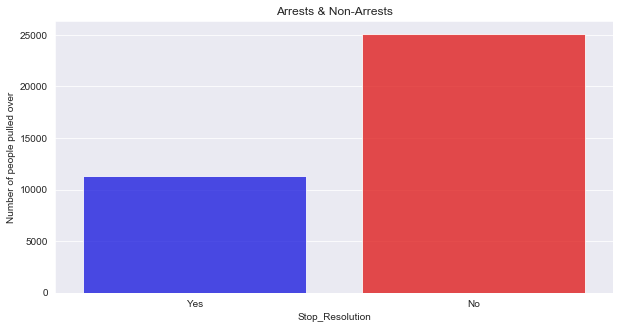

In [61]:
arrests = df['Stop_Resolution']=='Yes' 
non_arrests = df['Stop_Resolution']=='No'
y = df['Stop_Resolution']
num_of_arrests = df[arrests].shape[0]
num_of_nonarrests = df[non_arrests].shape[0]

print('Target Variable: Stop Resolution')
print('Total Arrests: ', num_of_arrests)
print('Total of Non-arrests: ', num_of_nonarrests)

sns.set_style('darkgrid');
plt.figure(figsize = (10,5));
sns.countplot(df['Stop_Resolution'], alpha = .80, palette= ['blue', 'red'])
plt.title('Arrests & Non-Arrests');

plt.ylabel('Number of people pulled over');
plt.show()

In [62]:
# Create bar charts to compare different columns against the arrrest data

Subject Age Group

Stop_Resolution      No   Yes  % of Stops Ending In Arrest
Subject_Age_Group                                         
1 - 17             1204   420                    25.862069
18 - 25            5155  2304                    30.888859
26 - 35            8480  4132                    32.762448
36 - 45            5511  2542                    31.565876
46 - 55            3391  1357                    28.580455
56 and Above       1344   523                    28.012855


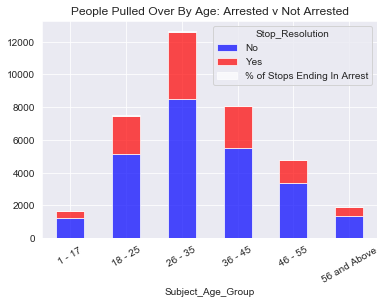

In [63]:
subject_age_group = df.groupby(['Subject_Age_Group', 'Stop_Resolution']).Subject_Age_Group.count().unstack()
subject_age_group['% of Stops Ending In Arrest'] = (subject_age_group['Yes'] / (subject_age_group.sum(axis=1)))*100 
print('Subject Age Group\n')
print(subject_age_group)

viz_1 = subject_age_group.plot(kind = 'bar', stacked = True,
                           title = "People Pulled Over By Age: Arrested v Not Arrested",
                           color = ['blue', 'red', 'white'], alpha = .70, rot=30)


Subject Perceived Race

Stop_Resolution                               No   Yes  \
Subject_Perceived_Race                                   
American Indian or Alaska Native             669   386   
Asian                                        801   417   
Black or African American                   7444  3795   
Hispanic                                     811   379   
Multi-Racial                                 404   155   
Native Hawaiian or Other Pacific Islander     41    18   
Unknown                                     2612   721   
White                                      12303  5407   

Stop_Resolution                            % of Stops Ending In Arrest  
Subject_Perceived_Race                                                  
American Indian or Alaska Native                             36.587678  
Asian                                                        34.236453  
Black or African American                                    33.766349  
Hispanic                      

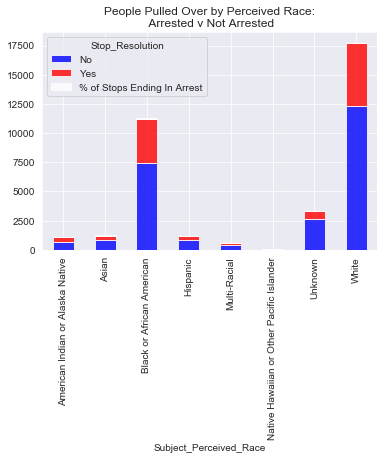

In [64]:
subject_perceived_race = df.groupby(['Subject_Perceived_Race', 'Stop_Resolution']).Subject_Perceived_Race.count().unstack()
subject_perceived_race['% of Stops Ending In Arrest'] = (subject_perceived_race['Yes'] / (subject_perceived_race.sum(axis=1)))*100 
print('Subject Perceived Race\n')
print(subject_perceived_race)

viz_2 = subject_perceived_race.plot(kind = 'bar', stacked = True,
                                   title = 'People Pulled Over by Perceived Race:\n Arrested v Not Arrested',
                                   color = ['blue', 'red','white'], alpha = .80, rot=90)


In [65]:
# It appears American Inidan/Native Alaskan have the highest percentage
# of arrests made after a Terry stop with nearly 37%. While important to note
# there were only 669 total stops of 36363 total in the data set. 
# The next highest was Asian with 34.2% , with Black, white, and Native Hawaiian
# at around 30% each.

Subject Perceived Gender

Stop_Resolution              No   Yes  % of Stops Ending In Arrest
Subject_Perceived_Gender                                          
Female                     5356  2151                    28.653257
Male                      19729  9127                    31.629470


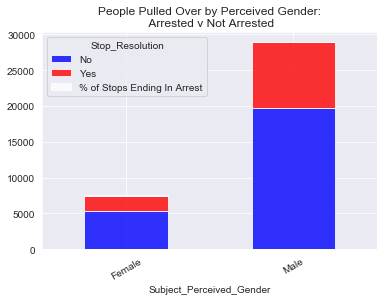

In [66]:
subject_perceived_gender = df.groupby(['Subject_Perceived_Gender', 'Stop_Resolution']).Subject_Perceived_Gender.count().unstack()
subject_perceived_gender['% of Stops Ending In Arrest'] = (subject_perceived_gender['Yes'] / (subject_perceived_gender.sum(axis=1)))*100 


print('Subject Perceived Gender\n')
print(subject_perceived_gender)

viz_3 = subject_perceived_gender.plot(kind = 'bar', stacked = True,
                                   title = 'People Pulled Over by Perceived Gender:\n Arrested v Not Arrested',
                                   color = ['blue', 'red','white'], alpha = .80, rot = 30)


In [67]:
# Male subjects were arrest 31% of the arrests while female subjects were 
# arrested 28.65%. While the male subjects were stopped nearly 4 times the rate
# of female, their arrest percentage was surprisingly close

Officer Gender

Stop_Resolution     No    Yes  % of Stops Ending In Arrest
Officer_Gender                                            
F                 2972   1177                    28.368282
M                22113  10101                    31.355932


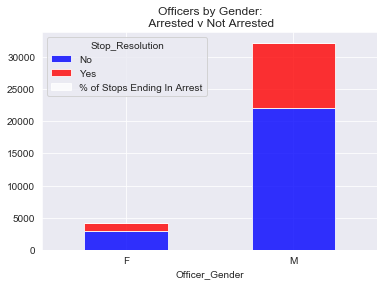

In [68]:
officer_gender = df.groupby(['Officer_Gender', 'Stop_Resolution']).Officer_Gender.count().unstack()
officer_gender['% of Stops Ending In Arrest'] = (officer_gender['Yes'] / (officer_gender.sum(axis=1)))*100 

print('Officer Gender\n')
print(officer_gender)

viz_4 = officer_gender.plot(kind = 'bar', stacked = True,
                                   title = 'Officers by Gender:\n Arrested v Not Arrested',
                                   color = ['blue', 'red','white'], alpha = .80, rot=0)


In [69]:
# Male cops arrested individuals 31% of those pulled over, while male officers
# arrested at a rate of 28%. 

Officer Race

Stop_Resolution                   No   Yes  % of Stops Ending In Arrest
Officer_Race                                                           
American Indian/Alaska Native    149    69                    31.651376
Asian                           1203   446                    27.046695
Black or African American       1023   323                    23.997028
Hispanic or Latino              1407   653                    31.699029
Nat Hawaiian/Oth Pac Islander    246    84                    25.454545
Other                            767   341                    30.776173
Two or More Races               1526   677                    30.730822
White                          18764  8685                    31.640497


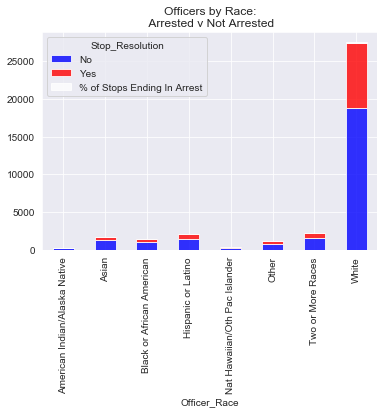

In [70]:
officer_race = df.groupby(['Officer_Race', 'Stop_Resolution']).Subject_Perceived_Race.count().unstack()
officer_race['% of Stops Ending In Arrest'] = (officer_race['Yes'] / (officer_race.sum(axis=1)))*100 

print('Officer Race\n')
print(officer_race)

viz_5 = officer_race.plot(kind = 'bar', stacked = True,
                                   title = 'Officers by Race:\n Arrested v Not Arrested',
                                   color = ['blue', 'red','white'], alpha = .80, rot=90)


In [71]:
# While white officers make up nearly 3 times the cops of all other races
# combined, they were actually in the middle of the pack in terms of 
# arrests made. Officers of two + races, Hispanic/Latino, and Asian officers
# were arresting at around ~25%.

Reported AM or PM

Stop_Resolution       No   Yes  % of Stops Ending In Arrest
Reported_AM_or_PM                                          
0                  11821  5286                    30.899632
1                  13264  5992                    31.117574


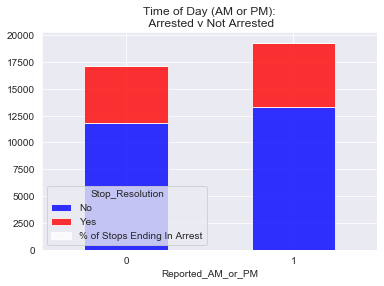

In [72]:
am_or_pm = df.groupby(['Reported_AM_or_PM', 'Stop_Resolution']).Reported_AM_or_PM.count().unstack()
am_or_pm['% of Stops Ending In Arrest'] = (am_or_pm['Yes'] / (am_or_pm.sum(axis=1)))*100 

print('Reported AM or PM\n')
print(am_or_pm)

viz_6 = am_or_pm.plot(kind = 'bar', stacked = True,
                                   title = 'Time of Day (AM or PM):\n Arrested v Not Arrested',
                                   color = ['blue', 'red','white'], alpha = .80, rot=0)


In [73]:
# There are more Terry stops in the PM hours than AM, however the percentages
# are less than 0.3% apart. 

Reported Hour

Stop_Resolution    No  Yes  % of Stops Ending In Arrest
Reported_Hour                                          
0                1170  517                    30.646117
1                1237  587                    32.182018
2                1527  606                    28.410689
3                1400  565                    28.753181
4                 766  377                    32.983377
5                 795  374                    31.993157
6                 651  320                    32.955716
7                 679  300                    30.643514
8                 687  347                    33.558994
9                 788  332                    29.642857
10               1078  409                    27.505044
11               1043  552                    34.608150
12                776  441                    36.236647
13                917  415                    31.156156
14               1076  443                    29.163924
15               1129  495       

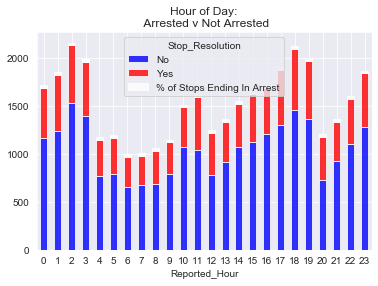

In [74]:
hour_of_day = df.groupby(['Reported_Hour', 'Stop_Resolution']).Reported_Hour.count().unstack()
hour_of_day['% of Stops Ending In Arrest'] = (hour_of_day['Yes'] / (hour_of_day.sum(axis=1)))*100 

print('Reported Hour\n')
print(hour_of_day)

viz_7 = hour_of_day.plot(kind = 'bar', stacked = True,
                                   title = 'Hour of Day:\n Arrested v Not Arrested',
                                   color = ['blue', 'red','white'], alpha = .80, rot=0)


In [75]:
# Looking at the data, arrests ebb and flow depending on time of day, 
# with peaks at midnight to 3am and 4pm to 7pm. However the highest
# percentage of arrests made at 11am and 12pm, over 1 percentage point
#away from the next two closest hours at 9am and 8pm. 

# Step 3: Model the Data

In [76]:
# Now that we've cleaned and visualized the data, now let's fit it into
# model. First starting with converting the target variable to binary,
# OneHotEncoding, then normalizing the data with StandardScalar


In [77]:
df['Stop_Resolution'] = df['Stop_Resolution'].apply(lambda x: 0 if x=='No' else 1)

df['Stop_Resolution'].value_counts()

0    25085
1    11278
Name: Stop_Resolution, dtype: int64

In [78]:
one_hot_df = pd.get_dummies(df)

y = one_hot_df['Stop_Resolution']
one_hot_df.drop('Stop_Resolution', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(one_hot_df, y, test_size=0.2, random_state=42)

In [79]:
scaler = StandardScaler()

scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

scaled_df_train = pd.DataFrame(scaled_data_train, columns=one_hot_df.columns)

In [80]:
scaled_df_train.head()

,Officer_YOB,Reported_Date,Reported_Hour,Reported_AM_or_PM,Subject_Age_Group_1 - 17,Subject_Age_Group_18 - 25,Subject_Age_Group_26 - 35,Subject_Age_Group_36 - 45,Subject_Age_Group_46 - 55,Subject_Age_Group_56 and Above,Officer_Gender_F,Officer_Gender_M,Officer_Race_American Indian/Alaska Native,Officer_Race_Asian,Officer_Race_Black or African American,Officer_Race_Hispanic or Latino,Officer_Race_Nat Hawaiian/Oth Pac Islander,Officer_Race_Other,Officer_Race_Two or More Races,Officer_Race_White,Subject_Perceived_Race_American Indian or Alaska Native,Subject_Perceived_Race_Asian,Subject_Perceived_Race_Black or African American,Subject_Perceived_Race_Hispanic,Subject_Perceived_Race_Multi-Racial,Subject_Perceived_Race_Native Hawaiian or Other Pacific Islander,Subject_Perceived_Race_Unknown,Subject_Perceived_Race_White,Subject_Perceived_Gender_Female,Subject_Perceived_Gender_Male,Frisk_Flag_0,Frisk_Flag_1,Precinct_East,Precinct_North,Precinct_South,Precinct_SouthWest,Precinct_West,Officer_Age_By_Decade_1900-1960,Officer_Age_By_Decade_1960s,Officer_Age_By_Decade_1970s,Officer_Age_By_Decade_1980s,Officer_Age_By_Decade_1990s,Time_of_Day_Afternoon,Time_of_Day_Morning,Time_of_Day_Night
0,0.386363,-0.726015,-1.070069,-1.060617,-0.216547,-0.505151,1.369852,-0.533967,-0.386808,-0.234803,-0.360029,0.360029,-0.079346,-0.218885,-0.192937,4.072796,-0.095333,-0.177137,-0.251844,-1.761194,-0.174121,-0.186815,1.490464,-0.183037,-0.124497,-0.038475,-0.316652,-0.972666,-0.512593,0.512593,-1.730861,1.730861,-0.448578,-0.619878,-0.423843,-0.315995,1.485572,-0.098228,-0.291968,-0.464741,1.101367,-0.627322,-0.706469,-0.546074,1.134200
1,0.731738,-1.025905,-1.486164,-1.060617,-0.216547,-0.505151,1.369852,-0.533967,-0.386808,-0.234803,-0.360029,0.360029,-0.079346,-0.218885,-0.192937,-0.245532,-0.095333,-0.177137,-0.251844,0.567797,-0.174121,-0.186815,-0.670932,-0.183037,-0.124497,-0.038475,3.158040,-0.972666,-0.512593,0.512593,-1.730861,1.730861,-0.448578,1.613219,-0.423843,-0.315995,-0.673142,-0.098228,-0.291968,-0.464741,-0.907963,1.594078,-0.706469,-0.546074,1.134200
2,-2.146385,-0.426125,0.178215,0.942847,-0.216547,1.979605,-0.730006,-0.533967,-0.386808,-0.234803,-0.360029,0.360029,-0.079346,-0.218885,-0.192937,-0.245532,-0.095333,-0.177137,-0.251844,0.567797,-0.174121,-0.186815,-0.670932,-0.183037,-0.124497,-0.038475,-0.316652,1.028102,1.950867,-1.950867,0.577747,-0.577747,-0.448578,-0.619878,2.359363,-0.315995,-0.673142,-0.098228,3.425033,-0.464741,-0.907963,-0.627322,1.415491,-0.546074,-0.881678
3,0.731738,1.373217,1.426499,0.942847,-0.216547,-0.505151,1.369852,-0.533967,-0.386808,-0.234803,-0.360029,0.360029,-0.079346,-0.218885,-0.192937,-0.245532,-0.095333,-0.177137,-0.251844,0.567797,-0.174121,-0.186815,-0.670932,-0.183037,-0.124497,-0.038475,-0.316652,1.028102,1.950867,-1.950867,0.577747,-0.577747,-0.448578,1.613219,-0.423843,-0.315995,-0.673142,-0.098228,-0.291968,-0.464741,-0.907963,1.594078,-0.706469,-0.546074,1.134200
4,1.307362,0.773437,0.871706,0.942847,-0.216547,-0.505151,-0.730006,-0.533967,-0.386808,4.258892,2.777553,-2.777553,-0.079346,-0.218885,-0.192937,4.072796,-0.095333,-0.177137,-0.251844,-1.761194,-0.174121,-0.186815,-0.670932,-0.183037,-0.124497,-0.038475,-0.316652,1.028102,-0.512593,0.512593,-1.730861,1.730861,-0.448578,-0.619878,2.359363,-0.315995,-0.673142,-0.098228,-0.291968,-0.464741,-0.907963,1.594078,1.415491,-0.546074,-0.881678


In [81]:
# Now that the data is OneHotEncoded and normalized, let's fit a model, 
# starting with a Logistic Regression model.

In [122]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
logreg.fit(scaled_data_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [123]:
y_hat_train = logreg.predict(scaled_data_train)
y_hat_test = logreg.predict(scaled_data_test)

In [124]:
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

Testing Accuracy:  0.5704661075209679


In [85]:
# Looking at the initial model, both the training and the test, both had an
# accuracy of 57%. We can definitely make this better using more sophisticated
# modeling. Next let's look at a confusion matrix to see where we can
# see how the model is performing



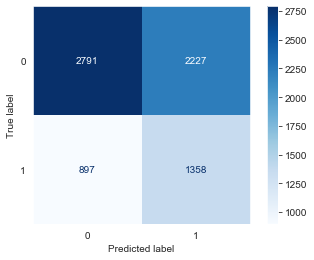

In [126]:
plot_confusion_matrix(logreg, scaled_data_test, y_test,
                     cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [87]:
# The model is correctly predicting stops ending in no arrest 4896 times
# while inccorectly predicting stops that were arrests as noa arrest 2163
# times. 

# Next let's check the Precision, Recall, Accuracy, and F1 scores. 

In [127]:
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))


Testing Accuracy:  0.5704661075209679
Testing Precision:  0.3788005578800558
Testing Recall:  0.6022172949002217
Testing F1-Score:  0.4650684931506849


In [128]:
# The recall and F1-score ar absolutely abysmal. The accuracy is 
# slightly better than a coinflip which isn't much to write home about.
# This time, we'll fit a K Nearest-Neighbors model to see if the data
# works better in that context. 

In [129]:
clf = KNeighborsClassifier()
clf.fit(scaled_data_train, y_train)
y_hat_train = clf.predict(scaled_data_train)
y_hat_test = clf.predict(scaled_data_test)


In [130]:
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Testing Accuracy:  0.6467757459095284
Testing Precision:  0.3969816272965879
Testing Recall:  0.2682926829268293
Testing F1-Score:  0.3201905265943371


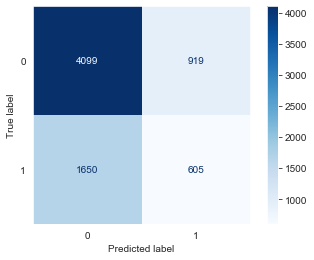

In [131]:
plot_confusion_matrix(clf, scaled_data_test, y_test,
                     cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [93]:
# The accuracy and precision went down
# slightly in comparison to the Logistic Regression output.
# A confusion matrix shows that it has only predicted '0', not
# a great sign.
# Since KNN has a default "neighbors" of 5, let's use GridSearchCV to 
# see if we can find a the best number of neighbors and run that
# model one more time. 

# Source of following code: Eijaz Allibhai (https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a)

In [94]:
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1,25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(scaled_data_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [95]:
knn_gscv.best_params_

{'n_neighbors': 24}

In [96]:
# Let's rerun the KNN model to see exactly how this 24 is the best neighbor

In [97]:
clf = KNeighborsClassifier(n_neighbors=24)
clf.fit(scaled_data_train, y_train)
y_hat_test = clf.predict(scaled_data_test)

In [98]:
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Testing Accuracy:  0.6837618589302901
Testing Precision:  0.4403183023872679
Testing Recall:  0.07361419068736141
Testing F1-Score:  0.12613981762917933


In [99]:
# Accuracy and precision are up but recall and are not great. 
# Let's move on to XGBoost

In [169]:
xgbc = XGBClassifier()
xgbc.fit(scaled_data_train, y_train)
y_hat_test = xgbc.predict(scaled_data_test)

In [170]:
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Testing Accuracy:  0.6902241165956277
Testing Precision:  0.5098039215686274
Testing Recall:  0.023059866962305987
Testing F1-Score:  0.044123886296139156


In [103]:
# Accuracy and Precision are up, but everything else is worse. 
# Let's try tuning XGBoost using GridSearchCV
# to see if we get better results. 

In [104]:
param_grid = {
    'learning rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [6],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.7, 0.9],
    'n_estimators': [100],
}

In [118]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(scaled_data_train, y_train)

best_parameters = grid_clf.best_params_

In [168]:
print(best_parameters)

{'learning rate': 0.1, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}


In [171]:
xgbc = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                    min_child_weight=2, subsample=0.9)
xgbc.fit(scaled_data_train, y_train)
y_hat_test = xgbc.predict(scaled_data_test)

In [172]:
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Testing Accuracy:  0.690774095971401
Testing Precision:  0.5081081081081081
Testing Recall:  0.08337028824833703
Testing F1-Score:  0.14323809523809525


In [115]:
# This is the highest our accuracy has been but barely. Was the 30
# minutes of loading this GridSearch worth it? 
# Let's move to a decision tree and see if we can get better than 
# 69% accuracy. 

In [139]:
SEED=1
dtc = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dtc.fit(scaled_data_train, y_train)

In [156]:
y_hat_test = dtc.predict(scaled_data_test)

print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Testing Accuracy:  0.6147394472707274
Testing Precision:  0.38580375782881005
Testing Recall:  0.4097560975609756
Testing F1-Score:  0.3974193548387097


In [141]:
SEED=1
dtc = DecisionTreeClassifier(criterion='gini', random_state=SEED)
dtc.fit(scaled_data_train, y_train)

In [153]:
y_hat_test = dtc.predict(scaled_data_test)

print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Testing Accuracy:  0.6147394472707274
Testing Precision:  0.38580375782881005
Testing Recall:  0.4097560975609756
Testing F1-Score:  0.3974193548387097


In [143]:
# The difference between 'gini' and 'entropy' were basically non existent.
# Let's try another GridSearch to see instead of manually changing parameters.
# Hopefully we can find the best decision tree.


In [157]:
dtc_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

dtc_grid = GridSearchCV(dtc, dt_param_grid, cv=3, return_train_score=True)

dtc_grid.fit(scaled_data_train, y_train)


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [159]:
dtc_grid.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [166]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=2,
                             min_samples_leaf=1, min_samples_split=2,
                             random_state=SEED)
dtc.fit(scaled_data_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [167]:
y_hat_test = dtc.predict(scaled_data_test)

print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Testing Accuracy:  0.6899491269077409
Testing Precision:  0.0
Testing Recall:  0.0
Testing F1-Score:  0.0


/Users/Garseed/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [174]:
# It seems as though we were unable to get enough data for testing
# metrics outside of Accuracy, probably deue to the low samples.

In [ ]:
# After running 7 models, the highest accuracy achieved was from an 
# XGBoost model with the best parameters found through GridSearchCV, 
# and even at that it was only able to be 69% accurate. 